### In this notebook, I test my implementation of fitting a Gaussian Mixture Model to a set of bivariate random variable. I do a clustering example. 

There are two parts:

1. I implement the expectation-maximization method
2. I compare it to the result with sklearn.mixture.GaussianMixture



In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
import copy
%matplotlib inline

In [2]:
L = 10
x1 = np.random.randint(low=0, high=L, size=4*L)
x2 = np.random.randint(low=0, high=L, size=4*L)
x= list(zip(x1,x2))

Text(0,0.5,'x_2')

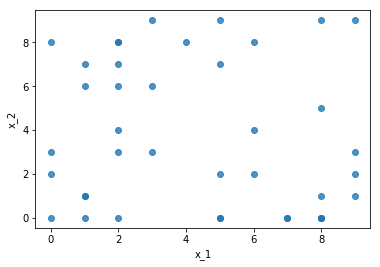

In [3]:
fig = sns.regplot(x1,x2, fit_reg=False)
fig.set_xlabel('x_1')
fig.set_ylabel('x_2')

# Let's fit a Gaussian Mixture Model

In [4]:
m = len(x) # number of observations
N = 2 # number of dimensions
k = 3 # number of clusters

In [5]:
def init_mu_sigma(k,N,x, debug=0):
   
    w = [0 for i in range(2)]
    w[0], w[1] = zip(*x)
    L = max(w[0])
    mu = np.array([np.zeros(N),np.zeros(N),np.zeros(N)])
    
    sigma = [0 for ii in range(k)]
    for ii in range(k): #Initialize mean variance 
        sigma[ii] = np.zeros([N,N])   
    mu[0] = np.array([np.random.randint(low=1,high=L), np.random.randint(low=1,high=L)])
    mu[1] = np.array([np.random.randint(low=1,high=L), np.random.randint(low=1,high=L)])
    mu[2] = np.array([np.random.randint(low=1,high=L), np.random.randint(low=1,high=L)])
    if debug ==1 : print(mu)
    
    for ik in range(k): #Initialize covariance for each Gaussian model
        for id in range(N): #for each dimension
            
            sigma[ik][id,id] = (1/m)*np.matmul(w[id]-mu[ik][id],w[id]-mu[ik][id])
        if debug == 1 : print(sigma[ik])
    
    prior_cl = [1/k for i in range(k)] #set prior to uniform distribution
        
    return mu, sigma, prior_cl

In [6]:
mu, sigma, prior_cl = init_mu_sigma(k,N,x, debug=0)

Let $z_i$ denote the hidden (latent) variable which we cannot measure. In this case, it represents the cluster label of point $x_i$. 

Given distribution parameters, find 
$$ p(z_i = k | x_i)   =\frac{p(x_i | z_i=k)p(z_i=k)}{\sum_{k'} p(x_i | z_i=k')p(z_i=k')}  = \frac{\mathcal{N}(\mu_k, \Sigma_k)p(z_i=k)}{\sum_{k'} p(x_i | z_i=k')p(z_i=k')} \quad \quad (1)$$   

where $\pi_k$ is the responsabilty vector.

## Expectation step : Compute equation (1)

In [7]:
def compute_post(m,k,x,mu,sigma, prior_cl):
    PostZ = np.zeros([m,k])
    for ix,iv in enumerate(x):   #for each data point
        for ik in range(k): # for each cluster 
            PostZ[ix,ik] = prior_cl[ik]*multivariate_normal.pdf(iv, mean=mu[ik], cov=sigma[ik])
        nc = sum(PostZ[ix,:])#normalize by sum of row
        PostZ[ix,:]= PostZ[ix,:]/nc
    return PostZ

In [8]:
#PostZ = compute_post(m,k,x,mu,sigma, prior_cl)

## Maximization of likelihood : Update parameters of GMM $\mu, \Sigma, \pi$ 

In [9]:
def update_params(m,k,x,mu,sigma, PostZ):
    # 1. Update priors
    for ik in range(k): 
        prior_cl[ik] = np.mean(PostZ[:,ik])

    if (abs(sum(prior_cl)-1) >0.001) : 
        print('Something went wrong: priors dont sum to one')

    #2. Update mean
    nk = [0 for i in range(k)]
    for ik in range(k): #Update mean of each cluster : weighted average
        nk[ik] = np.sum(PostZ[:,ik])
        mu[ik] = np.sum(np.reshape(PostZ[:,ik],[len(x),1])*np.array(x), axis=0)/nk[ik]
        #print(mu[ik])

    #3. Update Variance 
    for ik in range(k):
        sigma[ik][0,0],sigma[ik][1,1]= np.sum(np.reshape(PostZ[:,ik],[len(x),1])*(np.array(x)-mu[ik])*(np.array(x)-mu[ik]),axis=0)/nk[ik]

    return prior_cl, mu, sigma

In [10]:
## Run the Expectation Maximization itertively several steps

In [11]:
mu, sigma, prior_cl = init_mu_sigma(k,N,x, debug=0)
mu0 = copy.deepcopy(mu)
for it in range(100):     
    Postz = compute_post(m,k,x,mu,sigma, prior_cl)
    prior_cl, mu, sigma = update_params(m,k,x,mu,sigma, Postz)
hard_labels = np.argmax(Postz, axis=1)

In [12]:
# Let's put all the points in a dataframe to use seaborn to plot
df = pd.DataFrame()
df['x1'] = x1
df['x2'] = x2
df['cluster'] = hard_labels

In [13]:
def find_uncertain_points(df, Postz):
    soft = []
    for i in range(len(Postz)):
        if np.max(Postz[i,:]) > 0.6 : 
            soft.append(np.argmax(Postz[i,:]))
        else:
            print(i, Postz[i,:])
            soft.append(-1)
    df['cluster_p'] = soft
    return df

In [14]:
def define_color(x):
    colorvec=['c','b','g']
    if x>=0 :
        return colorvec[x]
    else:
        return 'k'

In [15]:
df = find_uncertain_points(df, Postz)
df['colorlab'] = df['cluster_p'].apply(define_color)

In [16]:
for ik in range(k):
    print('Cluster {0}, \n mu = {1}, \n sigma={2} \n'.format(ik,mu[ik], sigma[ik]))

Cluster 0, 
 mu = [ 1.38932127  3.47827451], 
 sigma=[[ 0.93525763  0.        ]
 [ 0.          7.19283921]] 

Cluster 1, 
 mu = [ 7.18788076  1.33912799], 
 sigma=[[ 2.07494441  0.        ]
 [ 0.          2.49865687]] 

Cluster 2, 
 mu = [ 4.59851413  8.26265087], 
 sigma=[[ 6.70039501  0.        ]
 [ 0.          0.51195509]] 



## Gaussian Mixture Models with Scikit package

In [17]:
from sklearn.mixture import GaussianMixture

In [18]:
cov_type='diag'
estimator = GaussianMixture(n_components=k,
                   covariance_type=cov_type, max_iter=20, random_state=0)
estimator.fit(x)    # Learns model parameters
y_pred = estimator.predict(x)
df['GMM'] = y_pred

Text(0.5,1,'Clustering with GMM \n size represents confidence')

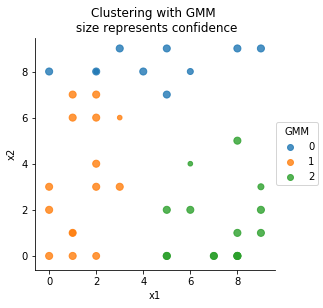

In [19]:
fig = sns.lmplot(x='x1',y='x2', data = df, size=4,hue='GMM', fit_reg=False, scatter_kws={"s": 50*(np.max(Postz, axis=1)**2)})
fig.ax.set_title('Clustering with GMM \n size represents confidence')

### Comparing visually the two clusterings side by side, we see there are some differences in points that are near the boundaray.

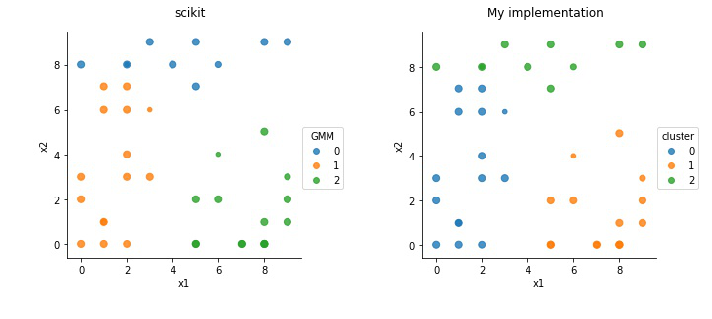

In [20]:
# Plot the two figs and save to temp files
sns.lmplot(x='x1',y='x2', data = df, hue='GMM', fit_reg=False, size=4,
           scatter_kws={"s": 50*(np.max(estimator.predict_proba(x), axis=1)**2)})  
plt.savefig('tmp1.jpg',bbox_inches='tight'); plt.close()
sns.lmplot(x='x1',y='x2', data = df, hue='cluster', fit_reg=False, size=4,
            scatter_kws={"s": 50*(np.max(Postz, axis=1)**2)})
plt.savefig('tmp2.jpg',bbox_inches='tight'); plt.close()

# Combine them with imshows
tit=['scikit','My implementation']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
for a in [1,2]: 
    ax[a-1].imshow(plt.imread('tmp%s.jpg' %a))
    ax[a-1].axis('off')
    ax[a-1].set_title(tit[a-1])
plt.tight_layout();
plt.savefig('GMM.jpg',bbox_inches='tight'); 

### If we want to see the probabilities of each point belonging to each cluster, use predict_proba() method :

In [21]:
estimator.predict_proba(x)

array([[  9.99965211e-01,   4.35140824e-11,   3.47889920e-05],
       [  7.51384439e-30,   9.99980242e-01,   1.97580218e-05],
       [  1.50820855e-23,   9.99822685e-01,   1.77315391e-04],
       [  5.73381164e-03,   9.94226082e-01,   4.01058786e-05],
       [  1.33964890e-01,   8.66034729e-01,   3.81496004e-07],
       [  6.26031126e-01,   3.73968872e-01,   2.48558802e-09],
       [  7.66002587e-18,   6.78901139e-14,   1.00000000e+00],
       [  1.53851706e-04,   9.72359239e-10,   9.99846147e-01],
       [  9.91230977e-01,   8.75161134e-03,   1.74119033e-05],
       [  1.50820855e-23,   9.99822685e-01,   1.77315391e-04],
       [  9.99748653e-01,   2.45769867e-04,   5.57718868e-06],
       [  5.10928441e-30,   2.78970658e-08,   9.99999972e-01],
       [  1.21882950e-23,   4.82663086e-14,   1.00000000e+00],
       [  1.00984567e-12,   1.24268749e-13,   1.00000000e+00],
       [  2.54693378e-02,   9.73299230e-01,   1.23143209e-03],
       [  6.45558073e-08,   6.06191210e-05,   9.9993931